In [1]:
%matplotlib inline

import sys
import os
sys.path.append('C:/Users/samrari/ComputBuffer')

import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
from my_packages.My_Geoprocess import*
import pandas as pd


In [2]:
class LyzengaMod:
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    
    def get_X(DeepSample, FootPrint, SoilIndex, bands_data):
        assert str(bands_data.dtype) == 'float32'
        X = np.zeros(bands_data.shape, dtype= np.float32)
        SoilIndex5D = np.tile(SoilIndex[:,:,np.newaxis], (1,1,bands_data.shape[2]))

        for i in range(len(FootPrint)):
            Idx = np.logical_and( np.logical_and(FootPrint[i], ~SoilIndex), np.sum(X == 0, axis=2)>0)

            if np.sum(Idx) > 0:
                IdxDeep = np.logical_and(FootPrint[i], DeepSample)
                if np.sum(IdxDeep) == 0:
                    IdxDeep = np.logical_and(FootPrint[i-1], DeepSample)

                for c in range(bands_data.shape[2]):
                    X[:,:,c][Idx] = bands_data[:,:,c][Idx] - np.min(bands_data[:,:,c][IdxDeep])
                    print('FootPrint: {0:d}, Bande: {1:d}, minimum :{2:0.2f}, average :{3:0.2f}'.format(i,c,np.min(bands_data[:,:,c][IdxDeep]), np.mean(bands_data[:,:,c][IdxDeep])))

        ErrorMap = np.logical_and(X<=0, ~SoilIndex5D)
        X[ErrorMap] = np.nan
        X[~SoilIndex5D] = np.log(X[~SoilIndex5D])
        return X, ErrorMap
    
    def __init__(self):
        """Constructeur de notre personne."""
        print("Appel de la méthode __init__")
        self.Parameters = []
        self.score = []

In [3]:
xml_filePath = "C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/"
xml_fileName = "MTD_MSIL1C.xml"
gdal.ErrorReset()
ds = gdal.Open( xml_filePath + xml_fileName )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
SubDataSet_md = ds.GetMetadata('SUBDATASETS')
ds = []
DataSet_md


{'CLOUD_COVERAGE_ASSESSMENT': '0.7371',
 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((166.35532632901763 -21.6970894719947, 166.46954229960608 -21.722967647825207, 166.46958826624325 -21.7227815159352, 166.47163316358743 -21.7232445791535, 166.4716453848504 -21.723194893765147, 166.47183341263485 -21.72323722848605, 166.4718497080836 -21.72317095690131, 166.71071733633568 -21.7773031127493, 166.71050830013448 -21.778173871448455, 166.9264041597562 -21.83047594674156, 166.92645036494807 -21.830281694363315, 166.92658079158798 -21.830313185021467, 166.9266070084699 -21.830202736161407, 166.92874668649648 -21.830719126399448, 166.928830

In [4]:
# Try opening the 4 subdatasets
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
src_ds = ds[0]
ds[0].RasterCount

4

In [5]:
# Define Raster Footprint

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
GT_ds = src_ds.GetGeoTransform()
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (165.9735606070099, -22.692427357900442) 
Lower right corner :  (167.02786117314153, -21.691015824552036)


In [6]:
RePath_xmlDirectory = 'C:/Users/samrari/ComputBuffer/Data_SHOM/Global'
TimeThres = 1965
#%timeit GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)

In [7]:
def GetSurvey_byDepthFP3(XML_List, RePath_xmlDirectory, E_range, N_range, max_Depth=40):
    # initilise
    Set_Point = []
    Set_Depth = []
    Set_xml = []
    countValidPT = []
    NoValid_xml = []
    for i, xml in enumerate(XML_List):
        # read current xml
        try:
            DepthPt = pd.read_csv(RePath_xmlDirectory+'/'+xml[:-10]+'ascii', delim_whitespace=True, header=None, names=['Lat','Lon','Depth'])
            # filter by depth
            DepthPt_40m = DepthPt[DepthPt['Depth']<=max_Depth]
            DepthPt_40m = DepthPt_40m[0<DepthPt_40m['Depth']]
            # loads points
            current_pt =  DepthPt_40m[['Lon','Lat']].values
            current_depth =  DepthPt_40m['Depth'].values
            # looks for points inside footprint
            index = isInsid2(current_pt[:,0], current_pt[:,1], E_range, N_range)
            if i == 8:
                print(index)
            # records points
            Set_Point.extend(current_pt[index,:])
            Set_Depth.extend(current_depth[index])
            root = ET.parse(RePath_xmlDirectory+'/'+xml).getroot()
            Set_xml.extend(np.tile((xml,root.find('Attribute[@name="SURSTA"]').find('Value').text),(np.sum(index), 1)))
            countValidPT.append(np.sum(index))     
        except:
            # in case of invalid xml path
            print('invalid at row: ', i)
            NoValid_xml.append(xml)
    return [np.asarray(Set_xml),  np.asarray(Set_Point), np.asarray(Set_Depth)], countValidPT, NoValid_xml

In [8]:
Upto = 100
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]

In [9]:

ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

px, py = GetPixel(ctInv, inv_geometrix, Set[1])

with int


In [10]:
index = np.logical_or(np.logical_or(py>10979,py<0), np.logical_or(px>10979,px<0))
px, py = px[~index], py[~index]
depth=Set[2][~index]
depth[:] = depth[:]+0.41

In [11]:
len(px)

18556254

In [28]:
npzfile = np.load('TrainMatrix_all.npz')
ClassifIndex =  npzfile['arr_1']

shapefile_path = ["D:/testInterp/error.shp"]

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
geo_transform = src_ds.GetGeoTransform()
proj = src_ds.GetProjectionRef()

errors = vectors_to_raster(shapefile_path, RasterWidth, RasterHeight, geo_transform, proj)
errors = errors==True
ClassifIndex[errors] = False
del errors,


In [30]:
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)


In [31]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.var(Dicto[(i, j)])
    

In [54]:
class1 = 'KmeansClassif_3Train1.1.tif'
file = 'C:/Users/samrari/ComputBuffer/Scripts/Classif/'
Classif = gdal.Open( file + class1 )
clusters_Classif = Classif.GetRasterBand(1).ReadAsArray()
np.unique(clusters_Classif)

array([0, 1, 2, 3], dtype=uint16)

In [22]:
for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = (clusters_Classif==i) * (SurveyIndex>0) 
    print(str(i)+':', str(np.sum(ind)),'et',str(np.median(SurveyValues[ind])),'et',str(np.std(SurveyValues[ind])), sep='\t')


1:	41329	et	10.51	et	4.53572542075
2:	113056	et	22.100625	et	9.83536288822
3:	471623	et	21.6440909091	et	7.40266949349


median:  10.51
median:  22.61
median:  21.8452941176


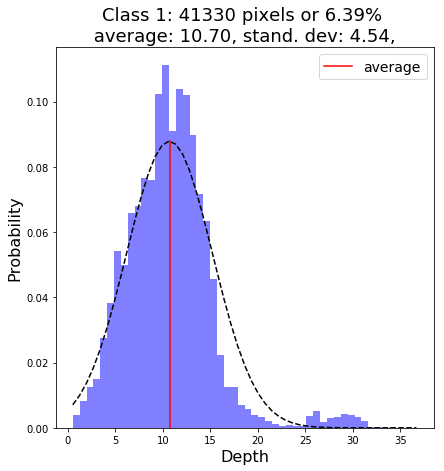

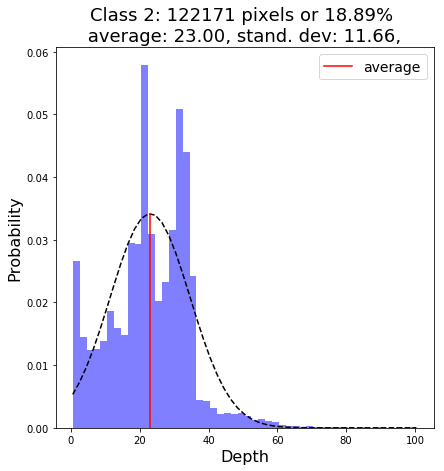

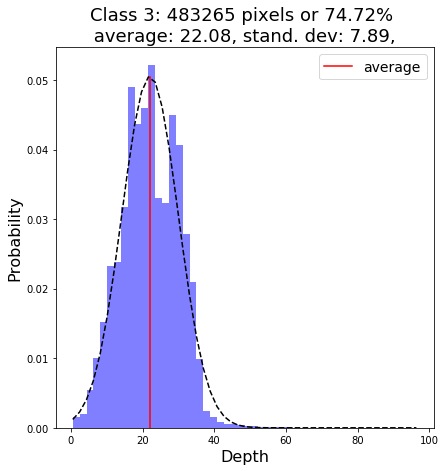

In [55]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

tot = len(SurveyValues[(clusters_Classif!=0) * (SurveyIndex>0)])

for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = (clusters_Classif==i) * (SurveyIndex>0) 
    fig = plt.figure(figsize= (7,7))

    mu = np.mean(SurveyValues[ind])
    med = np.median(SurveyValues[ind])
    print('median: ', med)
    sigma = np.std(SurveyValues[ind])

    num_bins = 50
    # the histogram of the data
    n, bins, patches = plt.hist(SurveyValues[ind], num_bins, normed=1, facecolor='blue', alpha=0.5)
    # add a 'best fit' line
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'k--')
    plt.plot([mu, mu], [0, np.max(y)], 'r-', label='average')
    plt.xlabel('Depth',fontsize=16)
    plt.ylabel('Probability',fontsize=16)
    plt.title('Class {0:d}: {1:d} pixels or {2:2.2f}% \n average: {3:2.2f}, stand. dev: {4:2.2f}, '.format(i, len(SurveyValues[ind]),100*len(SurveyValues[ind])/tot, mu, sigma),fontsize=18)
    plt.legend(fontsize=14)

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)

